# Домашнее задание Машинное обучение 2023

# Нурмухаметова Юлия 5030103 / 00301

In [1]:
import pandas as pd
import seaborn 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
data = pd.read_json('data.json')

In [3]:
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


В переменную data загрузили json файл с данными.\
Первая строка это id рецепта, представлена целочисленным числом int.\
Вторая строка это переменная, которую мы хотим научится предсказывать, представлена str.\
Третья строка это список ингредиентов, которые входят в рецепт, имеет вид list(str).

Проверим данные на пропуски

In [5]:
data.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

Пропусков в данных нет, но в таком виде не получится обучить модель, нужно как-то закодировать столбец ingredients.

Можно создать пустой dataframe из нулей с количеством строк равным количеству строк в исходных данных и с количеством столбцов равным количеству уникальных ингредиентов, составленных из всех ингредиентов, которые есть во всей таблице data, названия столбцов будут совпадать с названиями уникальных ингредиентов. После этого для каждого рецепта будем ставить в этом пустом dataframe в данной строке, в колонках с названиями ингредиентов 1, если он есть в рецепте и 0 если его нет. Таким образом получится разряженная матрица, по которой можно будет построить и обучить модель машинного обучения.  

In [6]:
ingredients_cols = list([])
for row in (data['ingredients']):
    for ingredient in row:
        ingredients_cols.append(ingredient)
ingredients_cols = list(set(ingredients_cols))
ingredients_cols[:5]    

['annatto oil',
 'low sodium chili sauce',
 'golden raisins',
 'accent',
 'chicken thighs']

In [7]:
len(ingredients_cols)

6714

Всего встречается 6714 ингредиентов.

In [8]:
ingredients_cols = pd.DataFrame(data=0, index=np.arange(data.shape[0]), columns=ingredients_cols)
ingredients_cols

,annatto oil,low sodium chili sauce,golden raisins,accent,chicken thighs,spicy sausage,chip plain tortilla,apricot brandy,low sodium vegetable juice,green grape,...,Knox unflavored gelatin,kasseri,nonfat cream cheese,young leeks,pearl onions,spaghetti sauce seasoning mix,reduced fat cream of mushroom soup,chocolate flavored liqueur,soft buns,baby carrots
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Объединим датафреймы

In [9]:
data = pd.concat([data, ingredients_cols], axis=1)
data

,id,cuisine,ingredients,annatto oil,low sodium chili sauce,golden raisins,accent,chicken thighs,spicy sausage,chip plain tortilla,...,Knox unflavored gelatin,kasseri,nonfat cream cheese,young leeks,pearl onions,spaghetti sauce seasoning mix,reduced fat cream of mushroom soup,chocolate flavored liqueur,soft buns,baby carrots
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
for i, ingredients_list in enumerate(data['ingredients']):
    for ingredient in ingredients_list:
        data.loc[i, ingredient] = 1
data

,id,cuisine,ingredients,annatto oil,low sodium chili sauce,golden raisins,accent,chicken thighs,spicy sausage,chip plain tortilla,...,Knox unflavored gelatin,kasseri,nonfat cream cheese,young leeks,pearl onions,spaghetti sauce seasoning mix,reduced fat cream of mushroom soup,chocolate flavored liqueur,soft buns,baby carrots
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили датафрейм, по которому можно обучить модель.

## Анализ данных с графиками

Найдем распределение целевой переменной - cuisine.

In [11]:
data['cuisine'].nunique()

20

Количество классов 20

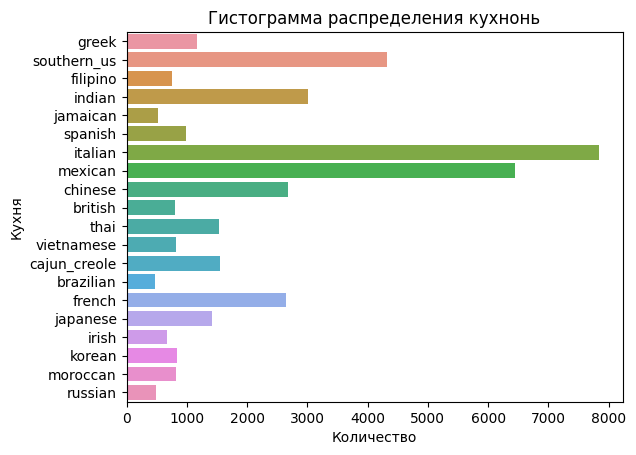

In [12]:
seaborn.countplot(data, y='cuisine')
plt.xlabel('Количество')
plt.ylabel('Кухня')
plt.title('Гистограмма распределения кухнонь')
plt.show()

Найдём самые популярные ингредиенты.

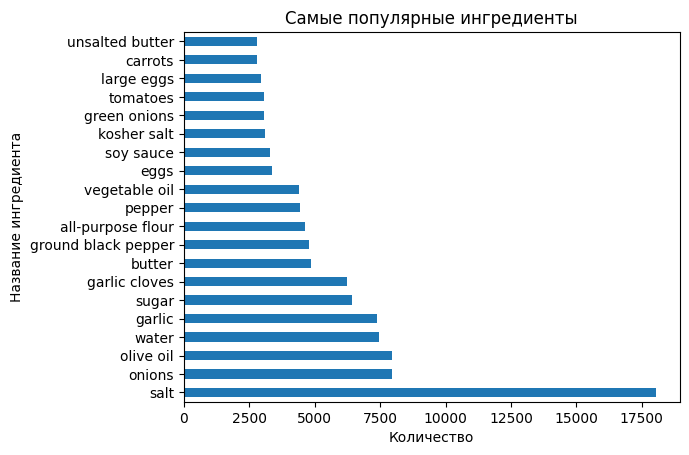

In [13]:
data.drop(columns=['id', 'cuisine', 'ingredients']).sum(axis=0).sort_values(ascending=False).head(20).plot(kind='barh')
plt.xlabel('Количество')
plt.ylabel('Название ингредиента')
plt.title('Самые популярные ингредиенты')
plt.show()

Найдём самые популярные ингредиенты для каждой кухни.

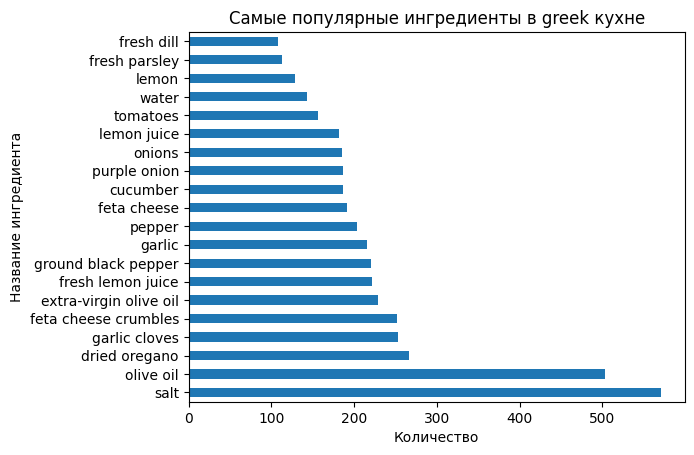

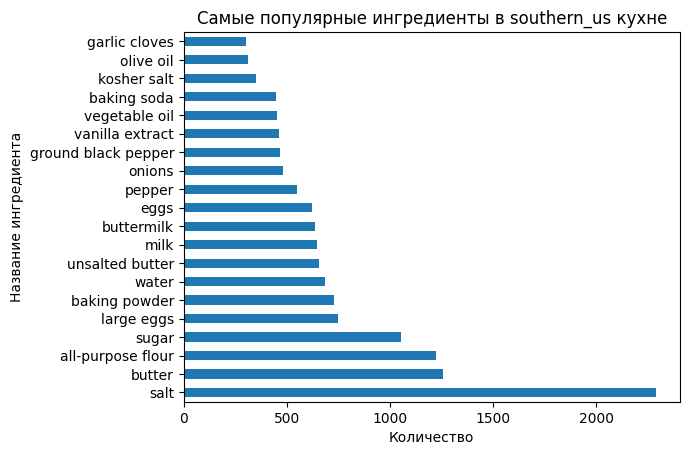

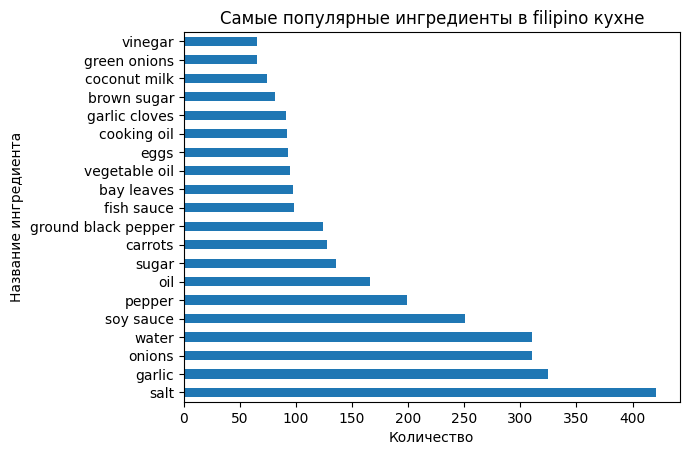

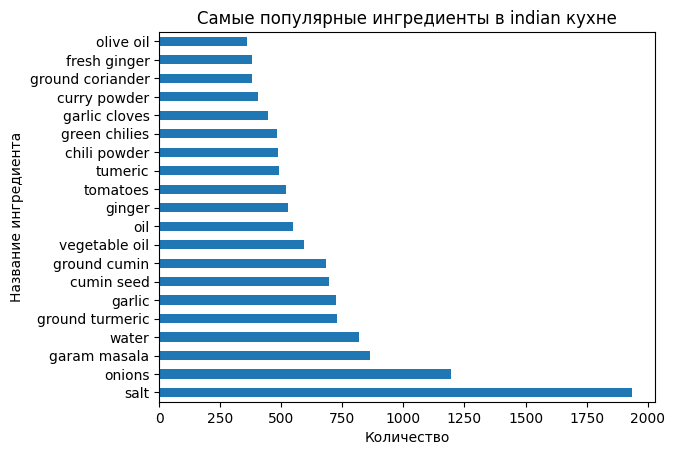

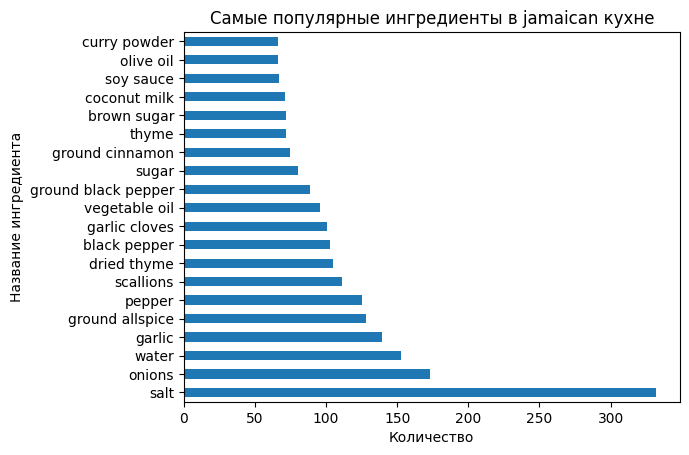

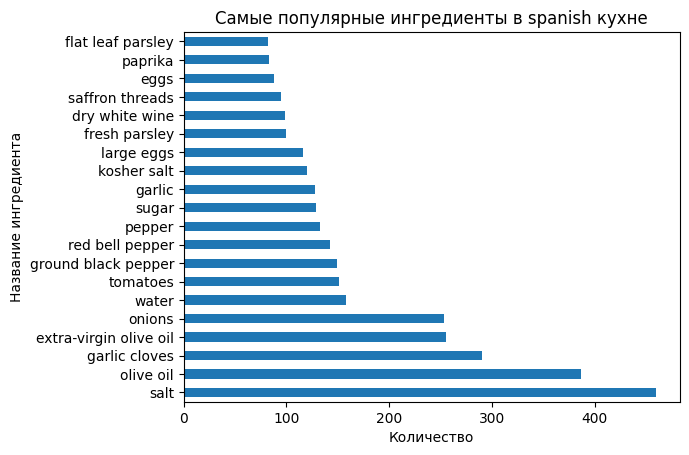

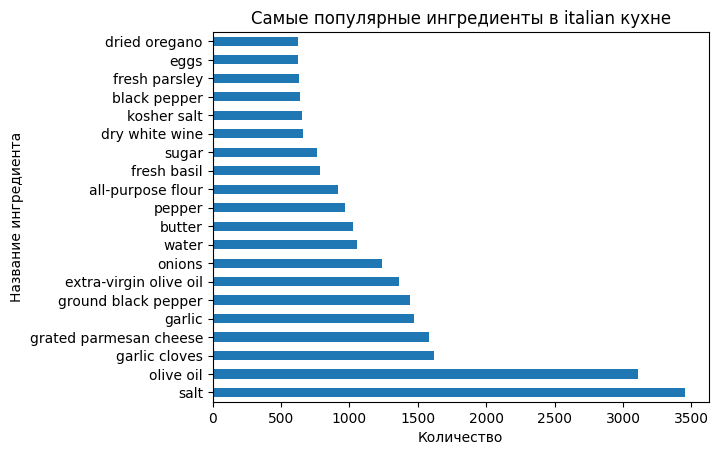

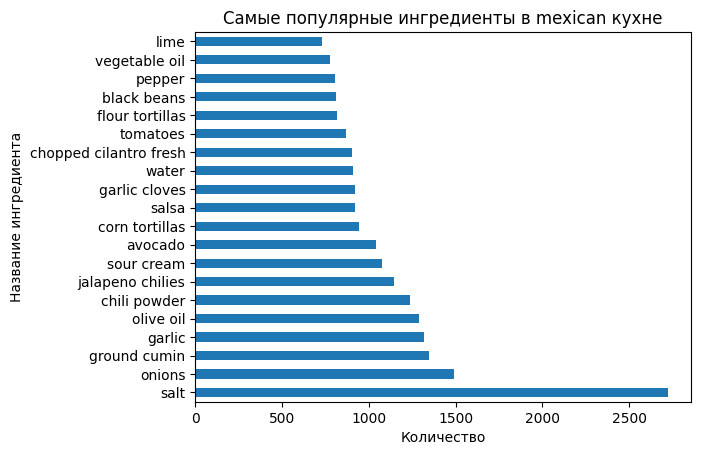

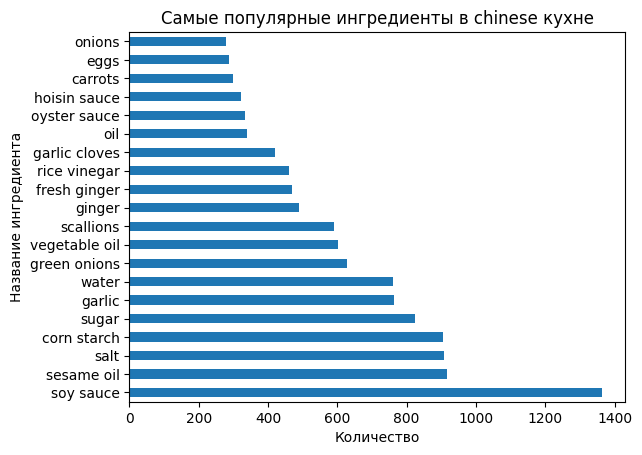

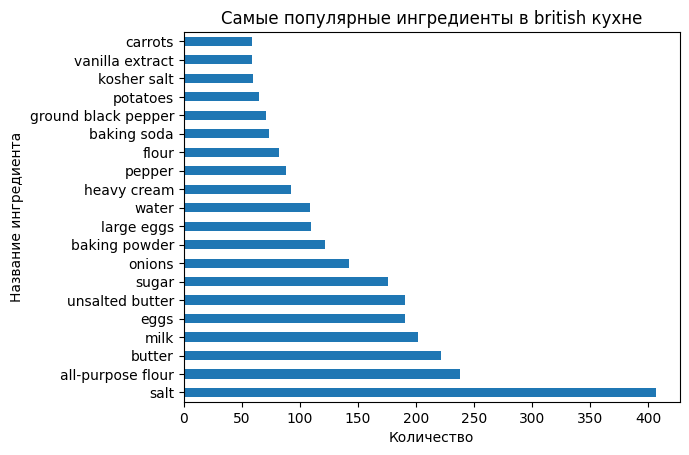

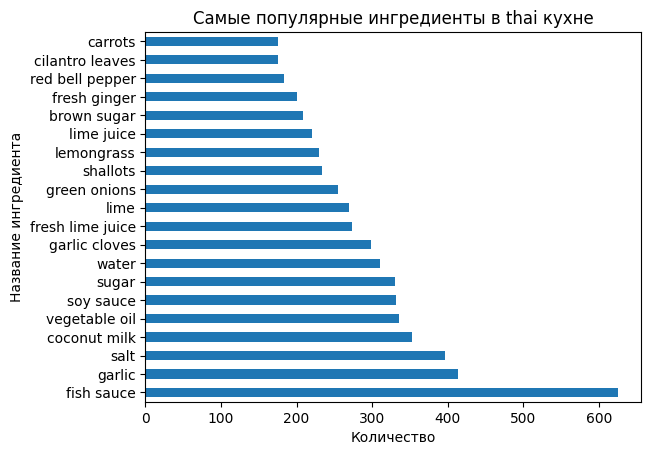

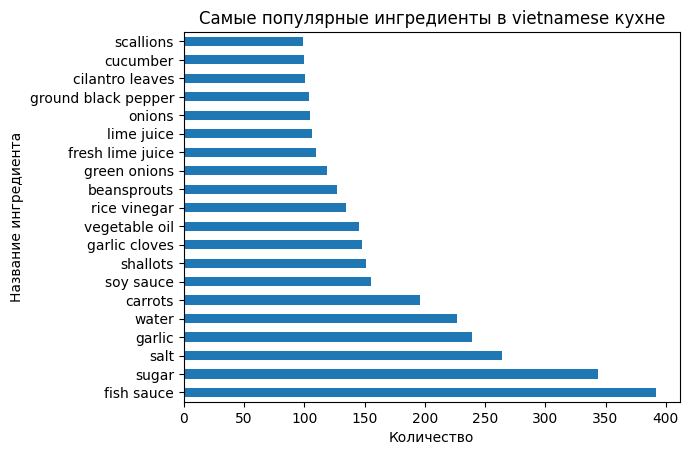

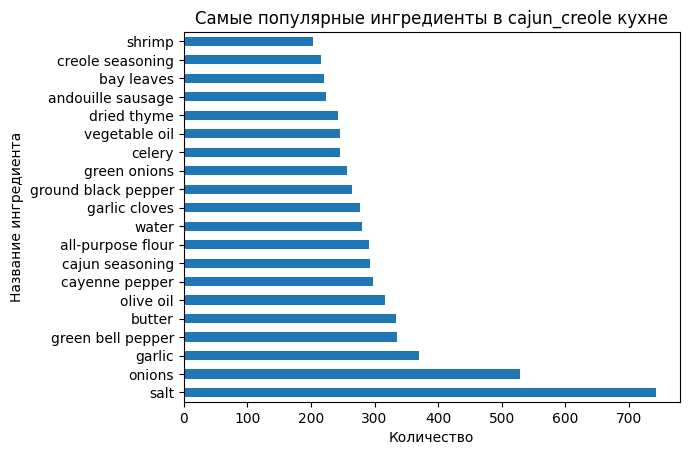

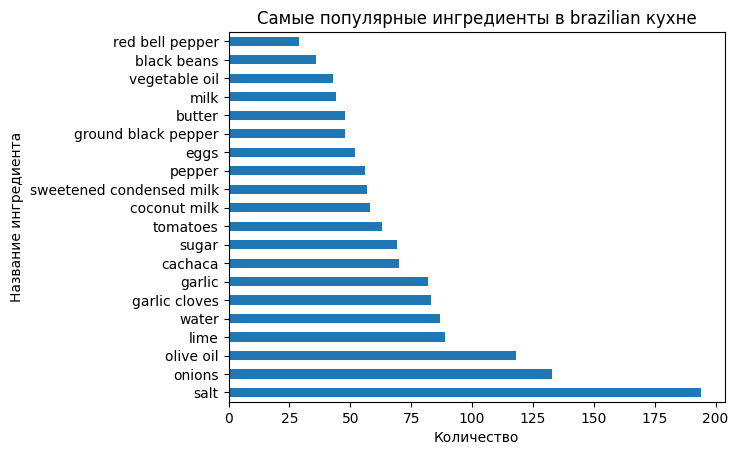

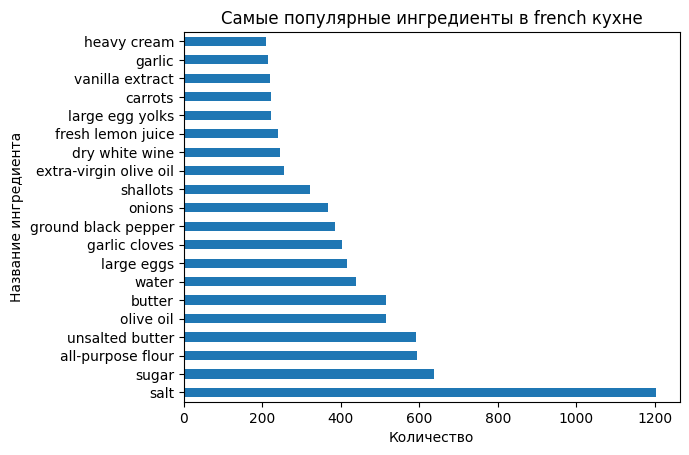

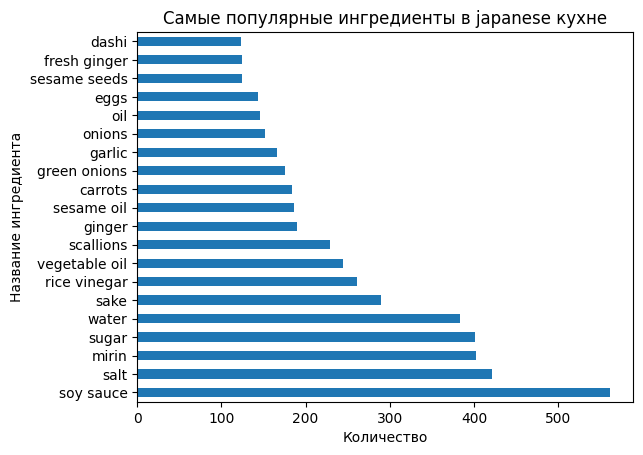

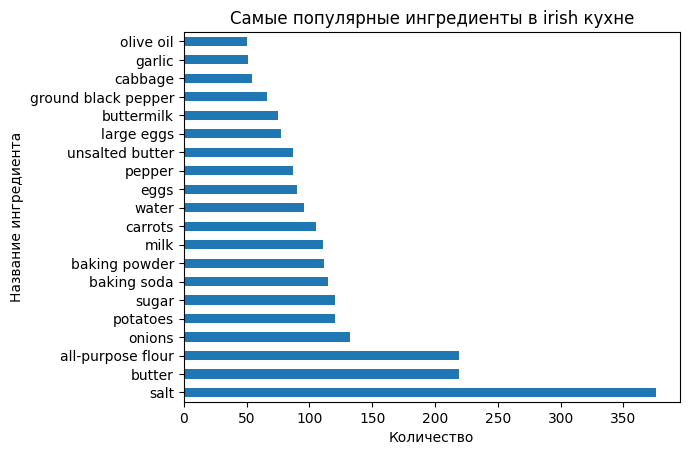

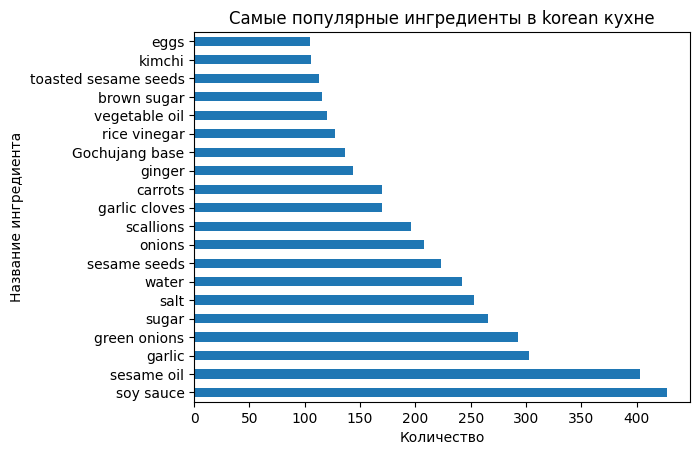

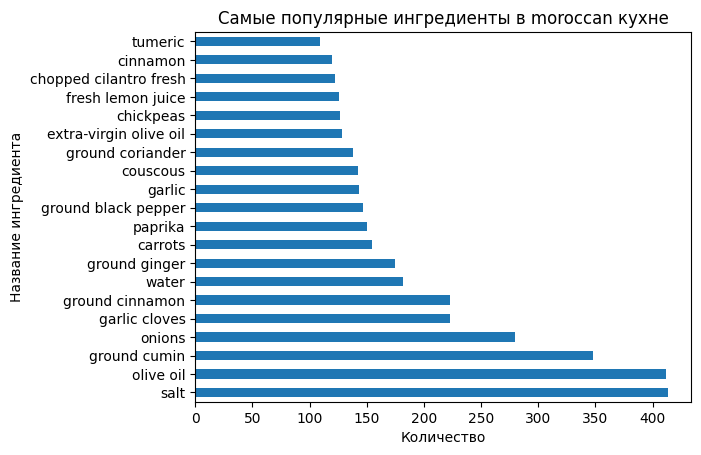

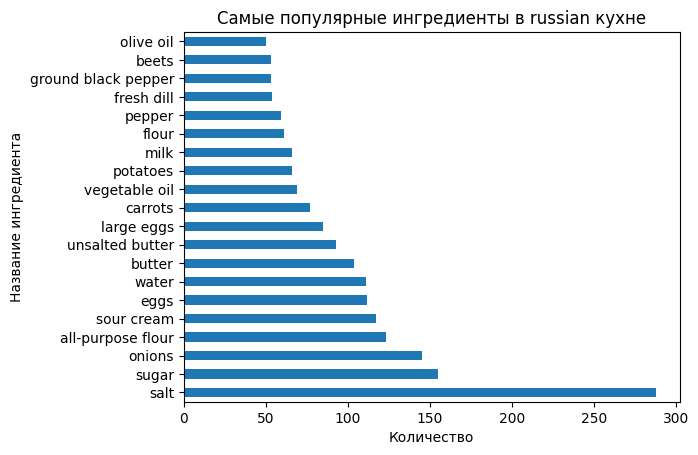

In [14]:
for cuisine_name in data['cuisine'].unique():
    data.drop(columns=['id', 'cuisine', 'ingredients'])[data['cuisine'] == cuisine_name]\
    .sum(axis=0)\
    .sort_values(ascending=False)\
    .head(20)\
    .plot(kind='barh')
    plt.xlabel('Количество')
    plt.ylabel('Название ингредиента')
    plt.title(f'Самые популярные ингредиенты в {cuisine_name} кухне')
    plt.show()


## Обучение моделей

In [15]:
label_enc = LabelEncoder()
label_enc.fit(data['cuisine'])
data['cuisine'] = label_enc.transform(data['cuisine'])
data

,id,cuisine,ingredients,annatto oil,low sodium chili sauce,golden raisins,accent,chicken thighs,spicy sausage,chip plain tortilla,...,Knox unflavored gelatin,kasseri,nonfat cream cheese,young leeks,pearl onions,spaghetti sauce seasoning mix,reduced fat cream of mushroom soup,chocolate flavored liqueur,soft buns,baby carrots
0,10259,6,"[romaine lettuce, black olives, grape tomatoes...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,16,"[plain flour, ground pepper, salt, tomatoes, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,4,"[eggs, pepper, salt, mayonaise, cooking oil, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,7,"[water, vegetable oil, wheat, salt]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,7,"[black pepper, shallots, cornflour, cayenne pe...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,8,"[light brown sugar, granulated sugar, butter, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,11462,9,"[KRAFT Zesty Italian Dressing, purple onion, b...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,2238,8,"[eggs, citrus fruit, raisins, sourdough starte...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,41882,3,"[boneless chicken skinless thigh, minced garli...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Выберем признаки (features) и целевую переменную (target).

In [16]:
features = data.drop(columns=['id', 'cuisine', 'ingredients'])
target = data['cuisine']

In [17]:
features

,annatto oil,low sodium chili sauce,golden raisins,accent,chicken thighs,spicy sausage,chip plain tortilla,apricot brandy,low sodium vegetable juice,green grape,...,Knox unflavored gelatin,kasseri,nonfat cream cheese,young leeks,pearl onions,spaghetti sauce seasoning mix,reduced fat cream of mushroom soup,chocolate flavored liqueur,soft buns,baby carrots
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
target

0         6
1        16
2         4
3         7
4         7
         ..
39769     8
39770     9
39771     8
39772     3
39773    13
Name: cuisine, Length: 39774, dtype: int32

Как сказано в задании поделим данные на тестовую и обучающую выборку в соотношении 3:7.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                   target,
                                                   random_state=310,
                                                   train_size=0.7,
                                                   stratify=target)

stratify=target был указан, чтобы учесть неравномерность данных, таким образом в тренировочную выборку попадут обекты всех классов

Проверим

In [20]:
y_train.value_counts()

cuisine
9     5486
13    4506
16    3024
7     2102
3     1871
5     1852
2     1082
18    1077
11     996
6      823
17     692
12     581
19     578
14     575
1      563
4      529
8      467
10     368
15     342
0      327
Name: count, dtype: int64

In [21]:
len(y_train.value_counts())

20

In [22]:
y_test.value_counts()

cuisine
9     2352
13    1932
16    1296
7      901
3      802
5      794
2      464
18     462
11     427
6      352
17     297
12     249
19     247
14     246
1      241
4      226
8      200
10     158
15     147
0      140
Name: count, dtype: int64

In [23]:
len(y_test.value_counts())

20

Таким образом в train и test выборку попали объекты всех классов несмотря на неравномерность.

Пройдёмся по моделям, которые были в слайдах лекции.

1) Логистическая регрессия

In [32]:
logistic_regression = LogisticRegression(n_jobs=-1)
logistic_regression.fit(X_train, y_train)
logistic_regression_score = accuracy_score(y_test, logistic_regression.predict(X_test))
print(f'Accuracy score of logistic regression = {logistic_regression_score}')

Accuracy score of logistic regression = 0.7725634794267996


2) Дерево решений

In [38]:
tree = DecisionTreeClassifier()
parameters = {'max_depth': [25, 50, 75, 100, 125, 150]}
grid_tree = GridSearchCV(estimator=tree, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_train, y_train)
print(f'Best parameters are {grid_tree.best_params_}')
tree = grid_tree.best_estimator_
tree_score = accuracy_score(y_test, tree.predict(X_test))
print(f'Accuracy score of tree = {tree_score}')

Best parameters are {'max_depth': 150}
Accuracy score of tree = 0.600351965138691


3) Бустинг

In [53]:
boosting_clf = LGBMClassifier(objective='multiclass', n_estimators=125)
boosting_clf.fit(X_train.values, y_train)
boosting_clf_score = accuracy_score(y_test, boosting_clf.predict(X_test.values))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 27841, number of used features: 1396
[LightGBM] [Info] Start training from score -4.444305
[LightGBM] [Info] Start training from score -3.900985
[LightGBM] [Info] Start training from score -3.247699
[LightGBM] [Info] Start training from score -2.700037
[LightGBM] [Info] Start training from score -3.963277
[LightGBM] [Info] Start training from score -2.710244
[LightGBM] [Info] Start training from score -3.521309
[LightGBM] [Info] Start training from score -2.583620
[LightGBM] [Info] Start training from score -4.087936
[LightGBM] [Info] Start training from score -1.624310
[LightGBM] [Info] Start training from score -4.326182
[LightGBM] [Info] Start training from score -3.3305

In [54]:
print(f'Accuracy score of boosting classifier = {boosting_clf_score}')

Accuracy score of boosting classifier = 0.7586524763261544


4) Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators=500, max_depth=200, n_jobs=-1)
rf.fit(X_train, y_train)
rf_score = accuracy_score(y_test, rf.predict(X_test))
print(f'Accuracy score of Random Forest = {rf_score}')

Accuracy score of Random Forest = 0.7130646107433168


## Результаты

В результате выполнения проекта, были прочитаны данные из json файла, закодированы в виде матрицы для возможности обучения моделей.\
Проанализированы гистограммы целевой переменной, найдены самые популярные ингредиенты в каждой кухне.\
Также были построены 4 модели машинного обучения.\
1) Логистическая регрессия. \
Accuracy score = 0.77
2) Дерево решений \
Accuracy score = 0.600351965138691
3) Бустинг \
Accuracy score = 0.76
4) Random Forest \
Accuracy score = 0.71

Лучший результат дали модели логитической регрессии и градиентного бустинга.\
Худший - дерево решений.